## Reproduce the LGT in [this paper](https://journals.aps.org/prx/pdf/10.1103/PhysRevX.10.021041)

In [48]:
from braket.ahs.hamiltonian import Hamiltonian
from braket.ahs.atom_arrangement import AtomArrangement
from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation

from ahs_utils import show_register, rabi_pulse, get_drive, get_shift, show_drive_and_shift, show_final_avg_density, get_avg_density

import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

from braket.devices import LocalSimulator
device = LocalSimulator("braket_ahs")

from braket.aws import AwsDevice 
qpu = AwsDevice("arn:aws:braket:us-east-1::device/qpu/quera/Aquila")

omega_max = 15800000
omega_slew_rate_max = 250000000000000.0
shift_max = 125000000.0
shift_slew_rate_max = 2500000000000000.0
tmin = 5e-8
t_ramp_omega = omega_max/omega_slew_rate_max
t_ramp_shift = shift_max/shift_slew_rate_max

print([t_ramp_omega, t_ramp_shift])

[6.32e-08, 5e-08]


# Define atom arrangement

In [89]:
N = 13 # 4n+1
a = 5.5e-6
register = AtomArrangement()
for ind in range(N):
    register.add([0, ind * a])
# show_register(register)


# Prepare initial states

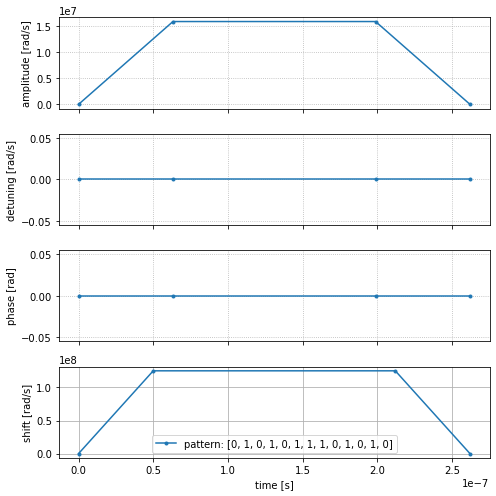

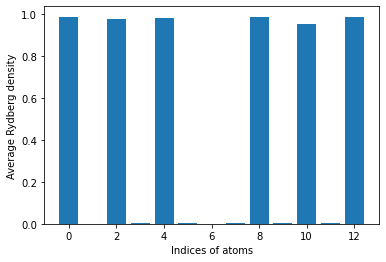

In [90]:
def prepare_states(
    indices, 
    omega_max=omega_max, 
    omega_slew_rate_max=omega_slew_rate_max, 
    shift_max=shift_max,
    register=register,    
    run_and_show = True
):
    """
    indices is a list of indices for the atoms that are in the rydberg states
    """
    
    time_points, amplitude_values = rabi_pulse(np.pi, omega_max, omega_slew_rate_max)
    phase_values = [0 for _ in range(len(time_points))]
    detuning_values = [0 for _ in range(len(time_points))]

    drive = get_drive(time_points, amplitude_values, detuning_values, phase_values)
    
    pattern = [1 for _ in range(len(register))]
    for ind in indices:
        pattern[ind]=0
        
    shift = get_shift(
        [0, t_ramp_shift, time_points[-1]-t_ramp_shift, time_points[-1]], 
        [0, shift_max, shift_max, 0], 
        pattern
    )
    
    if run_and_show:
        show_drive_and_shift(drive, shift)

        ahs_program = AnalogHamiltonianSimulation(
            hamiltonian=drive+shift,
            register=register
        )

        result = device.run(ahs_program, shots=1000, blockade_radius = a).result()
        show_final_avg_density(result)
        
    return time_points, amplitude_values, phase_values, detuning_values, shift

indices_ryd = [i for i in range(N) if np.mod(i, 2)==0 and i != N//2]

time_points_1, amplitude_values_1, phase_values_1, detuning_values_1, shift_1 = \
prepare_states(indices_ryd)

# Evolve

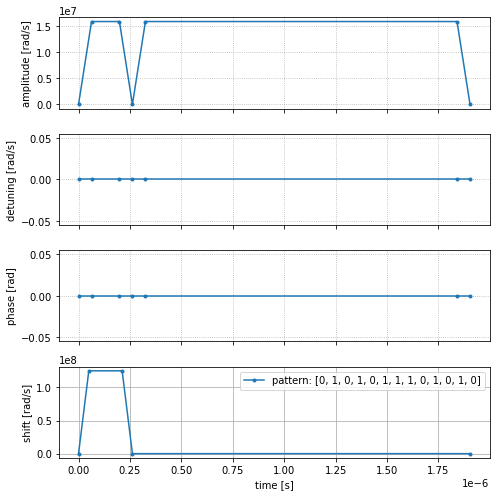

In [91]:
trange = np.linspace(0, 3e-6, 100)
programs = []
trange2 = []
for ind_t, t in enumerate(trange):
    time_points, amplitude_values = rabi_pulse(np.pi, omega_max, omega_slew_rate_max)
    time_initial_state = time_points[-1]
    time_points += [
        time_initial_state+t_ramp_omega, 
        time_initial_state+t_ramp_omega+t, 
        time_initial_state+2*t_ramp_omega+t
    ]
    amplitude_values += [omega_max, omega_max, 0]
    phase_values = [0 for _ in range(len(time_points))]
    detuning_values = [0 for _ in range(len(time_points))]
    
    drive = get_drive(time_points, amplitude_values, detuning_values, phase_values)

    pattern = [1 for _ in range(len(register))]
    for ind in indices_ryd:
        pattern[ind]=0
        
    shift = get_shift(
        [0, t_ramp_shift, time_initial_state-t_ramp_shift, time_initial_state, time_points[-1]], 
        [0, shift_max, shift_max, 0, 0], 
        pattern
    )

    programs.append(
        AnalogHamiltonianSimulation(
            hamiltonian=drive+shift,
            register=register
        )
    )
    trange2.append(time_points[-1])   
    
    if ind_t == len(trange)//2:
        show_drive_and_shift(drive, shift)


In [ ]:
densities = []
for ind, program in enumerate(programs):
    print(ind)
    result = device.run(program, shots=1000, steps = 100, blockade_radius = a).result()
    densities.append(get_avg_density(result))

0


In [ ]:
plt.figure(figsize = (8,10))

sns.heatmap(densities[::-1])
plt.xlabel("site")
plt.ylabel("time (microseconds)")
plt.yticks([len(trange2), 0], ["0", f"{trange2[-1]}"])
plt.show()
